# Simple Example on Self-Supervised Learning for Mitochondria Segmentation using PyTorch

One of the key challenges in training accurate and robust models for such tasks in the **medical image** domain is the scarcity of labeled data. This is where self-supervised learning comes into play, offering a powerful solution by leveraging unlabeled data to improve model performance.

Very briefly, self-supervised learning is a technique that derives supervisory signals from the data itself by defining **surrogate** or **proxy** tasks. These tasks do not require manual annotations but instead generate labels through automated processes. The self-supervised framework consists of two main steps:

1. **Pre-training**: The model is first trained on a proxy task designed to learn meaningful features from the data.
2. **Fine-tuning**: The pre-trained model is then adapted to the target downstream task, such as segmentation, using a smaller amount of labeled data.

The task I've chosen for this small guide is the mitochondria segmentation. The proxy task I'll focus on involves generating **pseudo-labels** for mitochondria segmentation using classical computer vision techniques. By pre-training a neural network with these pseudo-labels, I expect an improvement of the model's ability to accurately segment mitochondria in microscopy images during the fine-tuning stage.

I hope this notebook can guide you through the process of implementing a SSL framework for segmentation 😊. I made this image of the self-supervised learning framework to better visualize it:

<p align="center">
    <img src="ssl.png", weight="500", height="500"/>
</p>

### 1. Necesary libraries
* PyTorch
* Torchvision
* Numpy
* Matplotlib / OpenCV
* PIL


In [1]:
import os
import random
import torch
import torchvision
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader

"""
Set a global variable referencing the preferred device for the computations.
"""
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


### 2. Dataset Visualization and Pre-processing

I will be using the dataset [_Segmented anisotropic ssTEM dataset of neural tissue._](https://github.com/unidesigner/groundtruth-drosophila-vnc.git) from Stephan Gerhard et. al. It contains 8-bit grayscale microscopy images of the ventral nerve cord of the fruit fly Drosophila Melanogaster. You may find a better description of the dataset in its corresponding github page, but basically it provides **20 raw images** and their respective ground truth (binary) segmentation for **mitochondria, membranes and synapses**. Consider the following:

1. I will use **15 images for training** and the remaning **5 images for testing** from the _stack1_ directory.
2. Since images have a resolution of 1024x1024 pixels, which makes training expensive, I will use cropped 256x256 image patches instead.

In [2]:
class CustomDataset(Dataset):
    """
    Custom dataset for better data handling.
        - train: Specifies whether to retrieve the dataset for the training or testing phase.
        - crop: Indicates whether to use cropped images to reduce computational cost.
    """
    def __init__(self, train: bool = True, crop: bool = False):
        self.crop     = crop
        self.raw_path = 'groundtruth-drosophila-vnc-master/stack1/raw/'
        self.gt_path  = 'groundtruth-drosophila-vnc-master/stack1/mitochondria/'
        self.img_list = os.listdir(self.raw_path)[:15] if train else os.listdir(self.raw_path)[15:]
        self.gt_list  = os.listdir(self.gt_path)[:15] if train else os.listdir(self.gt_path)[15:]
        
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        totensor = torchvision.transforms.ToTensor() # Useful to convert the image arrays to tensors
        raw_img_path, gt_img_path = os.path.join(self.raw_path, self.img_list[idx]), os.path.join(self.gt_path, self.gt_list[idx])
        
        # Image read and conversion
        raw_img = Image.open(raw_img_path).convert('L') # Converts to grayscalse (1, dimensions)
        gt_img  = Image.open(gt_img_path).convert('L')  # Converts to grayscalse (1, dimensions)
        raw_img = totensor(raw_img)
        gt_img  = totensor(gt_img)

        # Image random crop
        if self.crop:
            raw_img, gt_img = self.randomCrop((256, 256), raw_img, gt_img)

        return raw_img, gt_img
    
    @staticmethod
    def randomCrop(size, image, label):
        """
        Static method to reduce the dimensionality of images by 
        returning cropped sections at random positions.
            - size: Specifies the crop size.
            - image: Input image to be cropped.
            - label: Ground truth image to be cropped at the same position as the raw image.
        """
        width, height = image.squeeze().size()

        if width < size[0]: # Pads the images height in case it is necessary (e.g., for other sizes different than 256)
            image = torchvision.transforms.functional.pad(image, (size[0] - image.shape[0], 0), 'constant')
            label = torchvision.transforms.functional.pad(label, (size[0] - image.shape[0], 0), 'constant')
        
        if height < size[1]: # Pads the images width in case it is necessary (same as above)
            image = torchvision.transforms.functional.pad(image, (0, size[1] - image.shape[1]), 'constant')
            label = torchvision.transforms.functional.pad(label, (0, size[1] - image.shape[1]), 'constant')

        # To have more meaningful patches, I return only images that have more than 10% of the positive values (sections with segmentation)
        while True:
            i, j = random.randint(0, (width - size[0])), random.randint(0, (height - size[0]))
            cropped_img = torchvision.transforms.functional.crop(image, j, i, size[1], size[0])
            cropped_lbl = torchvision.transforms.functional.crop(label, j, i, size[1], size[0])
            if (cropped_lbl == 1).sum(dim = 0).sum().item() > int(0.1 * size[1] * size[0]):
                return cropped_img, cropped_lbl

Data: torch.Size([15, 1, 1024, 1024]) / Label: torch.Size([15, 1, 1024, 1024])  / Iteration: 0 / Dataset Length: 1


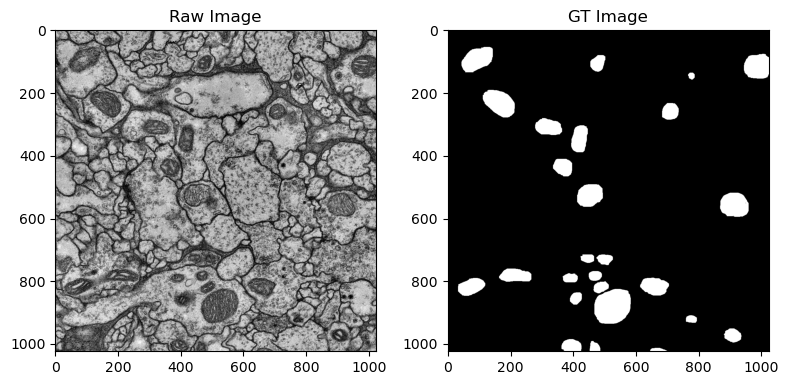

Data: torch.Size([15, 1, 256, 256]) / Label: torch.Size([15, 1, 256, 256])  / Iteration: 0 / Dataset Length: 1


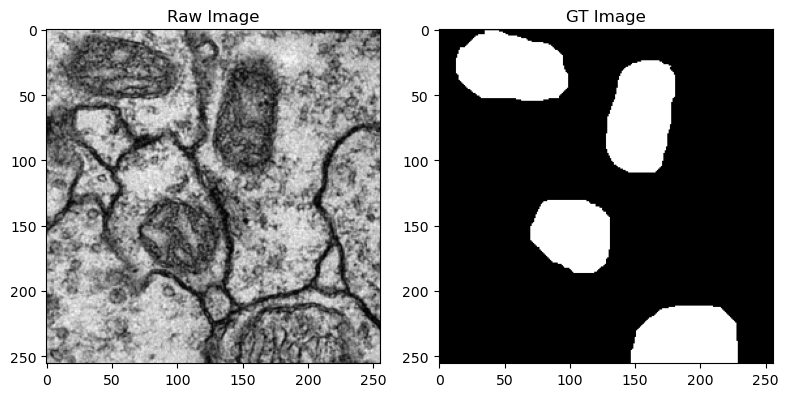

In [283]:
"""
Let's check how the images look like
"""

# Full resolution images:
train_dataset = DataLoader(CustomDataset(train = True, crop = False),
                           batch_size = 15, 
                           shuffle = False)
batch_id, (data, gt) = next(enumerate(train_dataset))
print(f"Data: {data.shape} / Label: {gt.shape}  / Iteration: {batch_id} / Dataset Length: {len(train_dataset)}")

_, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].imshow(data[0, 0], cmap="gray"), ax[0].set_title("Raw Image")
ax[1].imshow(gt[0, 0], cmap="gray"), ax[1].set_title("GT Image")
plt.tight_layout()
plt.show()

# Cropped images:
train_dataset_c = DataLoader(CustomDataset(train = True, crop = True),
                           batch_size = 15, 
                           shuffle = False)
batch_id, (data, gt) = next(enumerate(train_dataset_c))
print(f"Data: {data.shape} / Label: {gt.shape}  / Iteration: {batch_id} / Dataset Length: {len(train_dataset)}")

_, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].imshow(data[0, 0], cmap="gray"), ax[0].set_title("Raw Image")
ax[1].imshow(gt[0, 0], cmap="gray"), ax[1].set_title("GT Image")
plt.tight_layout()
plt.show()

In [105]:
"""
Why to use pytorch DataLoader? Let's see:
"""

# (1) Without DataLoader: single image is returned every iteration, and dataset length is 15
dataset = CustomDataset(train = True, crop = True)
batch_id, (data, gt) = next(enumerate(dataset))
print(f"(1) Data: {data.shape} / Label: {gt.shape}  / Iteration: {batch_id} / Dataset Length: {len(dataset)}")

# (2) With DataLoader: batch of images is returned, dataset length is 1 because there are no images left
dataset = DataLoader(CustomDataset(train = True, crop = True),
                     batch_size = 15, 
                     shuffle = False)
batch_id, (data, gt) = next(enumerate(dataset))
print(f"(2) Data: {data.shape} / Label: {gt.shape}  / Iteration: {batch_id} / Dataset Length: {len(dataset)}")


(1) Data: torch.Size([1, 256, 256]) / Label: torch.Size([1, 256, 256])  / Iteration: 0 / Dataset Length: 15
(2) Data: torch.Size([15, 1, 256, 256]) / Label: torch.Size([15, 1, 256, 256])  / Iteration: 0 / Dataset Length: 1


### 3. **Pre-Training Phase:** Self-Supervised Learning

Let's proceed with the first step of Self-Supervised Learning framework, where the model is trained on a **proxy task** designed to learn meaningful features from the data. This task is **binary segmentation**, which I will carry out by means of a Fully Convolutional Regression Network pre-trained on **self-generated** labels.

### 3.1. Model

The Fully Convolutional Regression model will have an **Encoder-Decoder** architecture. The following image summarizes the model:

<img src="model.png"/>

In [5]:
class FCRN(torch.nn.Module):
    """
    Fully Convolutional Regression Network model
        - in_channels: Input channels of the image.
        - out_channels: Initial latent space channels.
    """
    def __init__(self, in_channels = 1, out_channels = 32):
        super().__init__()
        # Encoder
        self.C1 = self._conv_block(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1) 
        self.C2 = self._conv_block(out_channels, out_channels * 2, kernel_size = 3, stride = 1, padding = 1) 
        self.C3 = self._conv_block(out_channels * 2, out_channels * 4, kernel_size = 3, stride = 1, padding = 1) 
        self.MP = torch.nn.MaxPool2d(kernel_size = 2, stride = 2) # To halve the dimensions
        
        # Latent Space
        self.C4 = self._conv_block(out_channels * 4, out_channels * 16, kernel_size = 3, stride = 1, padding = 1)
        
        # Decoder
        self.TC1 = self._transp_conv_block(out_channels * 16, out_channels * 4, kernel_size = 2, stride = 2, padding = 0)
        self.TC2 = self._transp_conv_block(out_channels * 4, out_channels * 2, kernel_size = 2, stride = 2, padding = 0)
        self.TC3 = self._transp_conv_block(out_channels * 2, out_channels, kernel_size = 2, stride = 2, padding = 0)
        self.C5  = torch.nn.Conv2d(out_channels, in_channels, kernel_size = 3, padding = 1) # 

        # Weight initialization
        self._weights_initializer()

    def forward(self, x):
        # Encoder
        x = self.MP(self.C1(x))
        x = self.MP(self.C2(x))
        x = self.MP(self.C3(x))

        # Latent Space
        x = self.C4(x)

        # Decoder
        x = self.TC1(x)
        x = self.TC2(x)
        x = self.TC3(x)

        return self.C5(x)

    def _conv_block(self, in_channels, out_channels, *, kernel_size, stride, padding):
        conv_block = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias = False), # No bias since we will use batch normalization
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace = True),
        )
        return conv_block
    
    def _transp_conv_block(self, in_channels, out_channels, *, kernel_size, stride, padding):
        tr_conv_block = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace = True)
        )
        return tr_conv_block
    
    # Weigth initialization
    def _weights_initializer(self):
        for module in self.modules():
            if isinstance(module, torch.nn.Conv2d):
                torch.nn.init.normal_(module.weight)
                if module.bias is not None:
                    torch.nn.init.constant_(module.bias, 0)
            if isinstance(module, torch.nn.ConvTranspose2d):
                torch.nn.init.normal_(module.weight)
                if module.bias is not None:
                    torch.nn.init.constant_(module.bias, 0)
            if isinstance(module, torch.nn.BatchNorm2d):
                if module.affine:
                    torch.nn.init.constant_(module.weight, 0.1)
                    torch.nn.init.constant_(module.bias, 0)

"""
Optional: Let's visualize the model summary
"""
try:
    import torchinfo
except ImportError:
    torchinfo = None

if torchinfo:
    model = FCRN().to(device)
    print(torchinfo.summary(model, input_size=(15, 1, 256, 256), depth=1))


Layer (type:depth-idx)                   Output Shape              Param #
FCRN                                     [15, 1, 256, 256]         --
├─Sequential: 1-1                        [15, 32, 256, 256]        352
├─MaxPool2d: 1-2                         [15, 32, 128, 128]        --
├─Sequential: 1-3                        [15, 64, 128, 128]        18,560
├─MaxPool2d: 1-4                         [15, 64, 64, 64]          --
├─Sequential: 1-5                        [15, 128, 64, 64]         73,984
├─MaxPool2d: 1-6                         [15, 128, 32, 32]         --
├─Sequential: 1-7                        [15, 512, 32, 32]         590,848
├─Sequential: 1-8                        [15, 128, 64, 64]         262,400
├─Sequential: 1-9                        [15, 64, 128, 128]        32,896
├─Sequential: 1-10                       [15, 32, 256, 256]        8,256
├─Conv2d: 1-11                           [15, 1, 256, 256]         289
Total params: 987,585
Trainable params: 987,585
Non-traina

### 3.2. Pseudo-label generator

To extract the pseudo-labels from the raw images, I will use common **computer vision** techniques along with some OpenCV functions.

In [147]:
def pseudo_labels(images):
    """
    I will execute the following image operations:
        1. Image Normalization
        2. Histogram Equalization
        3. Gaussian Blurring
        4. Binary Inversion Threshold
        5. Morphological Operations
    """
    self_generated_labels = []
    for image in images:
        image = image.squeeze().cpu().numpy()
        image = cv2.normalize(image, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8U) # Original image goes from 0 to 1
        image = cv2.equalizeHist(image)
        image = cv2.GaussianBlur(image, (3, 3), 1)
        _, image = cv2.threshold(image, thresh = 130, maxval = 255, type = cv2.THRESH_BINARY_INV)
        image = cv2.morphologyEx(image, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))   # Opening
        image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8))  # Closing

        image = np.where(image > 0, 1.0, 0.0) # To bring the image to the original scale
        self_generated_labels.append(image[None, ...])
    return torch.from_numpy(np.array(self_generated_labels))

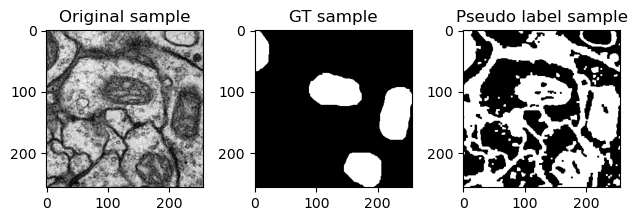

In [148]:
"""
Let's visualize our self-generated labels
"""
self_labels = pseudo_labels(data)
_, ax = plt.subplots(1, 3)
ax[0].imshow(data[0,0], cmap='gray'), ax[0].set_title("Original sample")
ax[1].imshow(gt[0,0], cmap='gray'), ax[1].set_title("GT sample")
ax[2].imshow(self_labels[0,0], cmap='gray'), ax[2].set_title("Pseudo label sample")
plt.tight_layout()
plt.show()

### 3.3. Segmentation Performance

In order to assess the effectiveness of the segmentation yielded by the model while training, I will compute the **Mean Intersection Over Union (IoU)** metric. This metric measures the overlap between the predicted segmentation and the ground truth, providing an indication of how well the predicted regions align with the actual regions of interest, i.e. the mitochondria cells.

In [151]:
def IoU(images, labels, device = torch.device("cpu")):
    """
    This function computes the Intersection over Union
    between the input images and labels.
    """
    iou = 0
    labels     = labels.type(torch.BoolTensor)
    ones_mask  = torch.ones_like(images, device = device)
    zeros_mask = torch.zeros_like(images, device = device)

    if images.shape[0] > 1:
        temp = torch.where(images >= 0.5, ones_mask, zeros_mask)
        intersection = (temp.squeeze().type(torch.BoolTensor) & labels.squeeze()).float().sum((1, 2))
        union = (temp.squeeze().type(torch.BoolTensor) | labels.squeeze()).float().sum((1, 2))
        iou += torch.mean((intersection + 0.0001) / (union + 0.0001)) # To avoid division by 0
    else:
        temp = torch.where(images >= 0.5, ones_mask, zeros_mask)
        intersection = (temp.squeeze().type(torch.BoolTensor) & labels.squeeze()).float().sum()
        union = (temp.squeeze().type(torch.BoolTensor) | labels.squeeze()).float().sum()
        iou += torch.sum((intersection + 0.0001) / (union + 0.0001)) # To avoid division by 0

    return iou

### 3.4. Now let's pre-train the model

Now we have all the elements to execute the pre-training phase of the Self-Supervised Learning framework by using the self-generated pseudo-labels 😊. I will use the following setup:

- Optimizer: Adam
- Learning rate: 0.005
- Loss function: Binary Cross Entropy (weighted)*
- Epochs: 100

**(!)** Bear in mind that as the number of pixels in the foreground might be lower than the pixels in the background, a weighted loss should be used to tackle this **class imbalance** problem. Specifically, the Binary Cross Entropy with appropriate weights can help balance the influence of foreground and background pixels during training.

In [168]:
"""
First, let's define a function to provide the weights
to the loss function w.r.t. the labels.
"""
def balanced_weights(labels):
    weights = torch.ones_like(labels)

    for label_idx in range(0, labels.shape[0]):
        pos_weight = torch.sum(labels[label_idx] == 1)
        neg_weight = torch.sum(labels[label_idx] == 0)
        weights[label_idx] = float(neg_weight.item() / pos_weight.item())

    return weights

In [249]:
"""
Now, let's finally pre-train the model on the self-generated labels
"""
# For replication, let's set a random seed
torch.manual_seed(0) 
random.seed(0)

# This is a dictionary to store the training performance measures
log_ssl_pretrain = {'loss': [], 'iou': []}

# Training data loader
train_loader = CustomDataset(train = True, crop = True) 
train_loader = torch.utils.data.DataLoader(train_loader, batch_size=15, shuffle=True)

# Settings
epochs = 100
model  = FCRN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# Pre-Train
model.train()
print(f'\nTraining')
for epoch in range(epochs):
    print("-" * 80)
    for batch_idx, (data, _) in enumerate(train_loader): # No need of labels in this first step
        # Generation of the pseudo-labels
        pseudo_gt = pseudo_labels(data).to(device)

        data = data.to(device)
        loss = torch.nn.BCEWithLogitsLoss(weight = balanced_weights(pseudo_gt)).to(device)
        
        # Without zeroing I'd end up with (full) batch gradient descent, which is undesired.
        optimizer.zero_grad()

        # Prediction 
        predicted_segmentation = model(data)

        # Measures
        bceloss = loss(predicted_segmentation, pseudo_gt)
        iou = IoU(predicted_segmentation, pseudo_gt, device=device)

        # Backward propagation and Optimization
        bceloss.backward()
        optimizer.step()

        if not batch_idx % 1:
            print(f'Epoch: {epoch+1:03}/{epochs:03} | Batch: {batch_idx:01}/{len(train_loader):01} | Loss: {bceloss.item():.4f} | IoU: {iou:.3f}') 
    # Logging per epoch
    log_ssl_pretrain['loss'].append(bceloss.item())
    log_ssl_pretrain['iou'].append(iou)



Training
--------------------------------------------------------------------------------
Epoch: 001/100 | Batch: 0/1 | Loss: 0.8826 | IoU: 0.390
--------------------------------------------------------------------------------
Epoch: 002/100 | Batch: 0/1 | Loss: 0.7187 | IoU: 0.386
--------------------------------------------------------------------------------
Epoch: 003/100 | Batch: 0/1 | Loss: 0.6235 | IoU: 0.345
--------------------------------------------------------------------------------
Epoch: 004/100 | Batch: 0/1 | Loss: 0.5883 | IoU: 0.336
--------------------------------------------------------------------------------
Epoch: 005/100 | Batch: 0/1 | Loss: 0.5362 | IoU: 0.398
--------------------------------------------------------------------------------
Epoch: 006/100 | Batch: 0/1 | Loss: 0.5020 | IoU: 0.457
--------------------------------------------------------------------------------
Epoch: 007/100 | Batch: 0/1 | Loss: 0.4618 | IoU: 0.539
-------------------------------

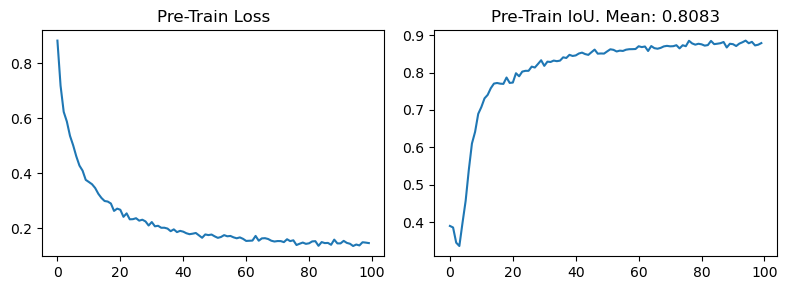

In [250]:
"""
Let's visualize the loss ans IoU evolution in this
first pre-training phase
"""
_, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].plot(log_ssl_pretrain['loss']), ax[0].set_title("Pre-Train Loss")
ax[1].plot(log_ssl_pretrain['iou']), ax[1].set_title(f'Pre-Train IoU. Mean: {np.mean(log_ssl_pretrain['iou']):.4f}')
plt.tight_layout()
plt.show()


### 4. **Fine-Tunning Phase:** Self-Supervised Learning

With the already pre-trained model, let's proceed with the **fine-tunning** phase of the Self-Supervised Learning framework, where the goal is to adapt the model to the target **downstream task**, which is the segmentation of the cellular data by only using the small amount of labeled ground truths. This time I will train for 200 epochs, making a total of 300 epochs if we consider the pre-training phase.

In [251]:
"""
Let's execute the final step of the SSL, i.e., 
fine-tunning on the scarce labeled dataset.
"""
# This is a dictionary to store the training performance measures
log_ssl_train = {'loss': [], 'iou': []}

# Training data loader
train_loader = CustomDataset(train = True, crop = True) 
train_loader = torch.utils.data.DataLoader(train_loader, batch_size=15, shuffle=True)

# Settings
epochs = 200
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# Fine-tunning (train)
model.train()
print(f'\nTraining')
for epoch in range(epochs):
    print("-" * 80)
    for batch_idx, (data, gt) in enumerate(train_loader): # We need the labels now
        data = data.to(device)
        gt   = gt.to(device)
        loss = torch.nn.BCEWithLogitsLoss(weight = balanced_weights(gt)).to(device)
        
        # Without zeroing I'd end up with (full) batch gradient descent, which is undesired.
        optimizer.zero_grad()

        # Prediction 
        predicted_segmentation = model(data)

        # Measures
        bceloss = loss(predicted_segmentation, gt)
        iou = IoU(predicted_segmentation, gt, device=device)

        # Backward propagation and Optimization
        bceloss.backward()
        optimizer.step()

        if not batch_idx % 1:
            print(f'Epoch: {epoch+1:03}/{epochs:03} | Batch: {batch_idx:01}/{len(train_loader):01} | Loss: {bceloss.item():.4f} | IoU: {iou:.3f}') 
    # Logging per epoch
    log_ssl_train['loss'].append(bceloss.item())
    log_ssl_train['iou'].append(iou)



Training
--------------------------------------------------------------------------------
Epoch: 001/200 | Batch: 0/1 | Loss: 9.4509 | IoU: 0.305
--------------------------------------------------------------------------------
Epoch: 002/200 | Batch: 0/1 | Loss: 9.1419 | IoU: 0.276
--------------------------------------------------------------------------------
Epoch: 003/200 | Batch: 0/1 | Loss: 6.5381 | IoU: 0.305
--------------------------------------------------------------------------------
Epoch: 004/200 | Batch: 0/1 | Loss: 3.3073 | IoU: 0.366
--------------------------------------------------------------------------------
Epoch: 005/200 | Batch: 0/1 | Loss: 2.4946 | IoU: 0.321
--------------------------------------------------------------------------------
Epoch: 006/200 | Batch: 0/1 | Loss: 2.0027 | IoU: 0.184
--------------------------------------------------------------------------------
Epoch: 007/200 | Batch: 0/1 | Loss: 2.2713 | IoU: 0.032
-------------------------------

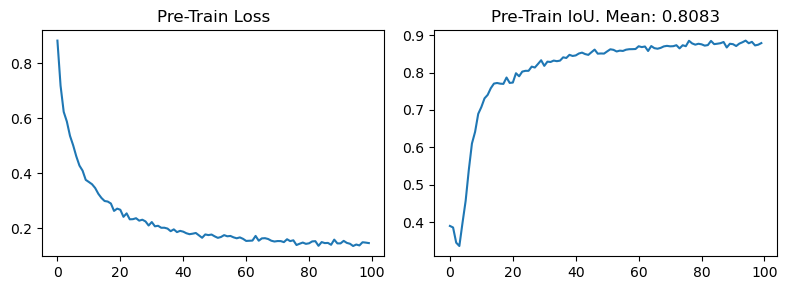

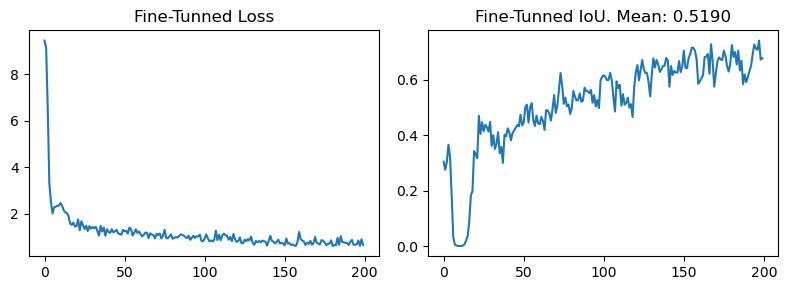

In [252]:
"""
Let's visualize our performance measures for the 
pre-training and the fine-tunning phase together.
"""
_, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].plot(log_ssl_pretrain['loss']), ax[0].set_title("Pre-Train Loss")
ax[1].plot(log_ssl_pretrain['iou']), ax[1].set_title(f'Pre-Train IoU. Mean: {np.mean(log_ssl_pretrain['iou']):.4f}')
plt.tight_layout()
plt.show()

_, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].plot(log_ssl_train['loss']), ax[0].set_title("Fine-Tunned Loss")
ax[1].plot(log_ssl_train['iou']), ax[1].set_title(f'Fine-Tunned IoU. Mean: {np.mean(log_ssl_train['iou']):.4f}')
plt.tight_layout()
plt.show()

### 4.1. Testing phase

We can now test the model on the remaining testing data, but this time using the **full-resolution** images. Let's do it.

In [253]:
"""
SSL model testing on the Full-Resolution Images
"""
# This is a dictionary to store the testing performance measures
log_ssl_test = {'loss': [], 'iou': []}

# Testing data loader
test_loader = CustomDataset(train = False, crop = False)
test_loader = torch.utils.data.DataLoader(test_loader, batch_size=5, shuffle=False)

# Testing phase
model.eval()
print(f'\nTesting')
with torch.no_grad():
    for batch_idx, (data, gt) in enumerate(test_loader):
        data = data.to(device)
        gt   = gt.to(device)
        loss = torch.nn.BCEWithLogitsLoss(weight = balanced_weights(gt)).to(device)

        # Prediction 
        predicted_segmentation = model(data)

        # Measures
        bceloss = loss(predicted_segmentation, gt)
        iou = IoU(predicted_segmentation, gt, device=device)

        if not batch_idx % 1:
            print(f'Batch: {batch_idx:01}/{len(train_loader):01} | Loss: {bceloss.item():.4f} | IoU: {iou:.3f}') 
    # Logging
    log_ssl_test['loss'].append(bceloss.item())
    log_ssl_test['iou'].append(iou)


Testing
Batch: 0/1 | Loss: 1.6158 | IoU: 0.481


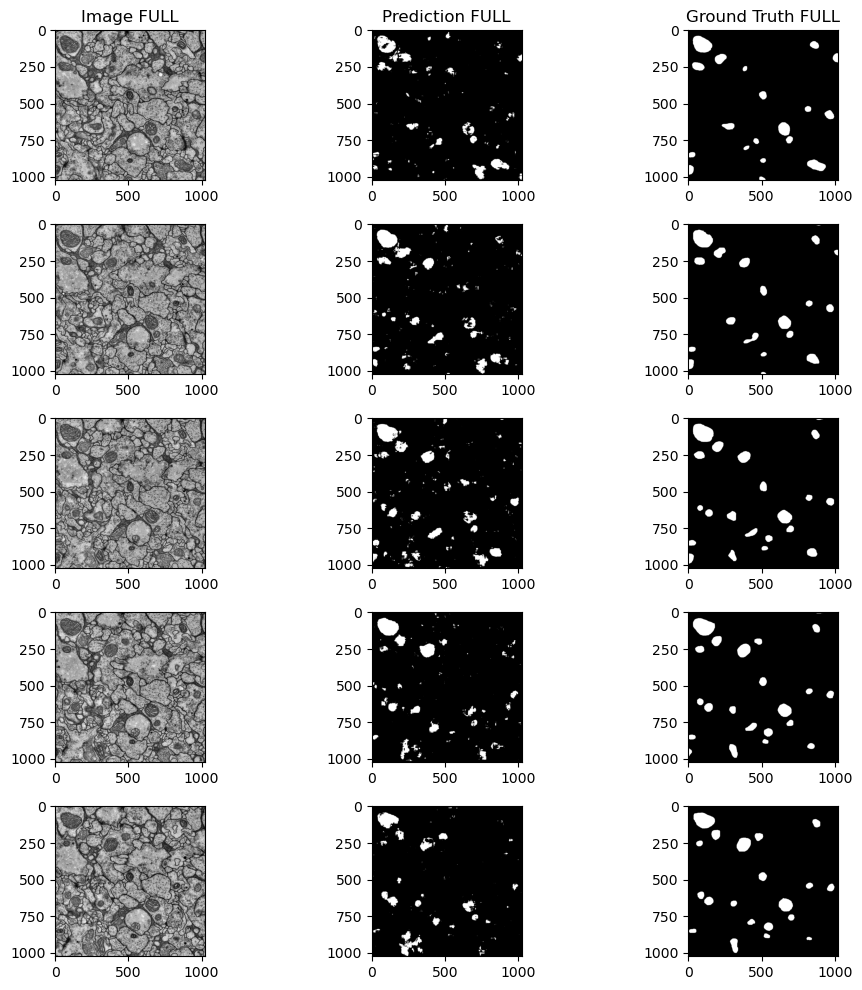

In [261]:
"""
Let's generate a prediction now and compare
with its corresponding ground truth.
"""
model.eval()
with torch.no_grad():
    predictionseg = model(data)

data_cpu = data.cpu().detach().numpy()
gt_cpu   = gt.cpu().detach().numpy()
pred_cpu = np.where(predictionseg.cpu().detach().numpy()  > 0.1, 1.0, 0.0) # Since the regression is computed btwn 0 and 1
_, ax = plt.subplots(5, 3, figsize=(10, 10))
for i in range(5):
    ax[i, 0].imshow(data_cpu[i, 0], cmap='gray'), ax[0, 0].set_title("Image FULL")
    ax[i, 1].imshow(pred_cpu[i, 0], cmap='gray'), ax[0, 1].set_title("Prediction FULL")
    ax[i, 2].imshow(gt_cpu[i, 0], cmap='gray'), ax[0, 2].set_title("Ground Truth FULL")
plt.tight_layout()
plt.show()

### 5. **Remarks:** Can Supervised Learning do better?

We have seen that the model does not perform flawlessly but that is because it needs **hyperparamenter tunning**, something that I won't discuss here but, can the simpler **Supervised Learning** framework perform better under the same training setup? Let's check that.

In [263]:
"""
Let's train a completely supervised model with the
same setup as the Self-Supervised Learning model.
"""
# For replication, let's set a random seed
torch.manual_seed(0) 
random.seed(0)

# This is a dictionary to store the training performance measures
log_sl_train = {'loss': [], 'iou': []}

# Training data loader
train_loader = CustomDataset(train = True, crop = True) 
train_loader = torch.utils.data.DataLoader(train_loader, batch_size=15, shuffle=True)

# Settings
epochs = 200 # Between pre-training and fine-tunning, the SSL trains for 300 epochs. Give it a try!
model_sl  = FCRN().to(device)
optimizer = torch.optim.Adam(model_sl.parameters(), lr=0.005)

# Pre-Train
model_sl.train()
print(f'\nTraining')
for epoch in range(epochs):
    print("-" * 80)
    for batch_idx, (data, gt) in enumerate(train_loader):
        data = data.to(device)
        gt   = gt.to(device)
        loss = torch.nn.BCEWithLogitsLoss(weight = balanced_weights(gt)).to(device)
        
        # Without zeroing I'd end up with (full) batch gradient descent, which is undesired.
        optimizer.zero_grad()

        # Prediction 
        predicted_segmentation = model_sl(data)

        # Measures
        bceloss = loss(predicted_segmentation, gt)
        iou = IoU(predicted_segmentation, gt, device=device)

        # Backward propagation and Optimization
        bceloss.backward()
        optimizer.step()

        if not batch_idx % 1:
            print(f'Epoch: {epoch+1:03}/{epochs:03} | Batch: {batch_idx:01}/{len(train_loader):01} | Loss: {bceloss.item():.4f} | IoU: {iou:.3f}') 
    # Logging per epoch
    log_sl_train['loss'].append(bceloss.item())
    log_sl_train['iou'].append(iou)


Training
--------------------------------------------------------------------------------
Epoch: 001/200 | Batch: 0/1 | Loss: 6.7870 | IoU: 0.146
--------------------------------------------------------------------------------
Epoch: 002/200 | Batch: 0/1 | Loss: 5.1630 | IoU: 0.165
--------------------------------------------------------------------------------
Epoch: 003/200 | Batch: 0/1 | Loss: 4.2201 | IoU: 0.159
--------------------------------------------------------------------------------
Epoch: 004/200 | Batch: 0/1 | Loss: 3.2960 | IoU: 0.141
--------------------------------------------------------------------------------
Epoch: 005/200 | Batch: 0/1 | Loss: 2.5363 | IoU: 0.086
--------------------------------------------------------------------------------
Epoch: 006/200 | Batch: 0/1 | Loss: 2.1953 | IoU: 0.042
--------------------------------------------------------------------------------
Epoch: 007/200 | Batch: 0/1 | Loss: 2.1184 | IoU: 0.025
-------------------------------

In [264]:
"""
Now, let's test the supervised model we
have just trained.
"""
# This is a dictionary to store the testing performance measures
log_sl_test = {'loss': [], 'iou': []}

# Testing data loader
test_loader = CustomDataset(train = False, crop = False)
test_loader = torch.utils.data.DataLoader(test_loader, batch_size=5, shuffle=False)

# Testing phase
model_sl.eval()
print(f'\nTesting')
with torch.no_grad():
    for batch_idx, (data, gt) in enumerate(test_loader):
        data = data.to(device)
        gt   = gt.to(device)
        loss = torch.nn.BCEWithLogitsLoss(weight = balanced_weights(gt)).to(device)

        # Prediction 
        predicted_segmentation = model_sl(data)

        # Measures
        bceloss = loss(predicted_segmentation, gt)
        iou = IoU(predicted_segmentation, gt, device=device)

        if not batch_idx % 1:
            print(f'Batch: {batch_idx:01}/{len(train_loader):01} | Loss: {bceloss.item():.4f} | IoU: {iou:.3f}') 
    # Logging
    log_sl_test['loss'].append(bceloss.item())
    log_sl_test['iou'].append(iou)


Testing
Batch: 0/1 | Loss: 1.8871 | IoU: 0.557


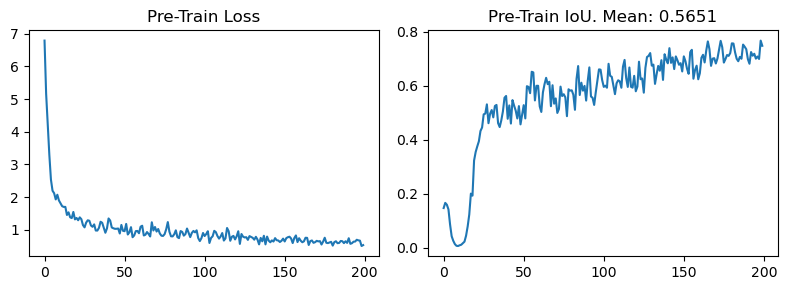

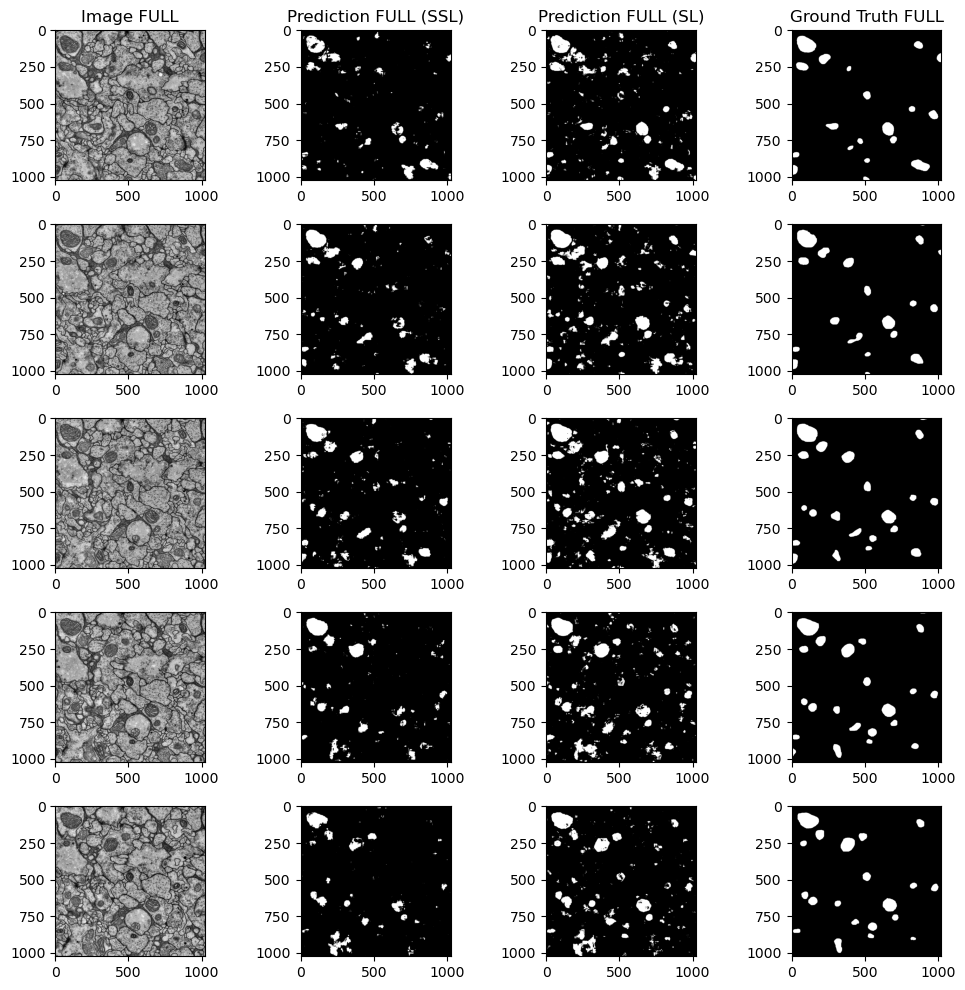

In [265]:
"""
Let's visualize the loss ans IoU evolution of the
supervised model while training, as well as the comparison
between the predictions of the Self-Supervised Learning
and the Supervised Learing approaches.
"""
_, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].plot(log_sl_train['loss']), ax[0].set_title("Pre-Train Loss")
ax[1].plot(log_sl_train['iou']), ax[1].set_title(f'Pre-Train IoU. Mean: {np.mean(log_sl_train['iou']):.4f}')
plt.tight_layout()
plt.show()

model_sl.eval()
with torch.no_grad():
    predictionseg_sl = model_sl(data)

data_cpu = data.cpu().detach().numpy()
gt_cpu   = gt.cpu().detach().numpy()
pred_cpu_sl = np.where(predictionseg_sl.cpu().detach().numpy()  > 0.1, 1.0, 0.0) # Since the regression is computed btwn 0 and 1
_, ax = plt.subplots(5, 4, figsize=(10, 10))
for i in range(5):
    ax[i, 0].imshow(data_cpu[i, 0], cmap='gray'), ax[0, 0].set_title("Image FULL")
    ax[i, 1].imshow(pred_cpu[i, 0], cmap='gray'), ax[0, 1].set_title("Prediction FULL (SSL)")
    ax[i, 2].imshow(pred_cpu_sl[i, 0], cmap='gray'), ax[0, 2].set_title("Prediction FULL (SL)")
    ax[i, 3].imshow(gt_cpu[i, 0], cmap='gray'), ax[0, 3].set_title("Ground Truth FULL")
plt.tight_layout()
plt.show()

## Final comments:

Although the testing loss and the IoU measure are better for the Supervised Learning (SL) approach (when trained for **300 epochs**) compared to the Self-Supervised Learning (SSL) model, it is noteworthy that the SSL model produces **less noisy** segmentations than the SL model. This indicates that SSL can be particularly effective in scenarios where cleaner segmentation outputs are crucial. In turn, if you train the SL model for **200 epochs**, it's performance will be significantly worse than the performance of the SSL. Give it a try!

It should be also noted that my objective with this notebook is to guide you through the process of implementing a simple SSL framework, but I did not check extensively for the best **hyperparameter initialization**, something that can lead to an improved performance in comparison to the SL model.

**Without more to say, I hope you found it useful, thank you!**

**-Julián H.** 😊